<a href="https://colab.research.google.com/github/Xixaus/Standard_add/blob/main/Kalibra%C4%8Dka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metoda kalibrační přímky

Program slouží k výpočtu koncentrace vzorku pomocí metody kalibrační přímky, vyhodnocení a vytvoření příslušného grafu

Nejdříve se připojte k hostujícímu prostředí v pravé horní části (musíte být přihlášený ke Google účtu)

Poté zadejte do první buňky hodnoty !podle návodu!, výpočet a graf vygenerujete spuštěním druhé buňky tlačítkem ▶ v levém horním rohu vedle nadpisu

Při prvním spuštění se instaluje potřebná knihovna, tak to trvá déle, další výpočty jsou okamžité

!!!Všechny objemy zadávejte ve stejných jednotkách, jednotlivá měření stejného roztoku oddělujte pomocí středníku (;), odezvy a objemy jednotlivých standardů pomocí lomítka (/)!!!

V_unit: zadejte jednotku objemu, ve které budete zadávat všechny objemy (bez indexů)
c_unit: zadejte jednotku koncentrace standardu (bez indexů)
R_unit: zadejte jednotku měřené veličiny, která bude na y ose v grafu
R_standard: zadejte odezvy odezvy standardů (např: 0.365; 0.360; 0.375 / 0.514; 0.51; 0.518)
c_standards: zadejte koncetrace standardů
R_sample: zadejte odezvy vzorku, v přídapě vyhodnocení více vzorků, oddělte odezvy / (např: 0.200; 0.204; 0.206 / 0,305; 0,325)
Fz: nastavuje se faktor zředění vzorků

Pomocí volby intercept se provede regrese s úsekem. V případě že je úsek nevýznamný, bude tato skutečnost červěně napsána pod první tabulkou.

Volbou DeanDixon_test se u vzorků provede Dean-Dixonův test na odlehlost

V případě že nějaká hodnota v kalibrační závislosti je odlehlá, tak bude červěně zvýrazněna v tabulce na test odlehlých hodnot.

In [5]:
#@title Vstupní hodnoty { run: "auto", vertical-output: true }
c_unit = 'mg/l' #@param {type:"string"}
R_unit = "A" #@param {type:"string"}

R_standards = "0,152;0,149/0,31;0,316/0,432;0,432/0,554;0,554/0,608;0,62"#@param {type:"string"}
c_standards = "0,1/0,2/0,3/0,4/0,5"#@param {type:"string"}

R_sample = "0,315;0,31/0,305;0,25" #@param {type:"string"}
Fz =  1#@param {type:"number"}
full_summary = False #@param {type:"boolean"}
intercept = True #@param {type:"boolean"}
DeanDixon_test = False #@param {type:"boolean"}

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.974
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0623      0.021      2.982      0.018       0.014       0.110
Concentration     1.1680      0.063     18.544      0.000       1.023       1.313



,Concentration,Signal,G
1,0.1,0.152,1.08
2,0.1,0.149,1.19
3,0.2,0.310,0.56
4,0.2,0.316,0.80
5,0.3,0.432,0.77
6,0.3,0.432,0.77
7,0.4,0.554,0.97
8,0.4,0.554,0.97
9,0.5,0.608,1.52
10,0.5,0.620,1.04


,Vzorek 1,Vzorek 2
1,0.315,0.305
2,0.31,0.25
Průměr,0.312,0.277
-----,-----,-----
Koncetrace analytu [mg/l],0.214,0.184
Směrodatná odchylka [mg/l],0.019,0.019
Relativní směrodatná odchylka %,8.7,10.2
Interval spolehlivosti 95%,0.043,0.043


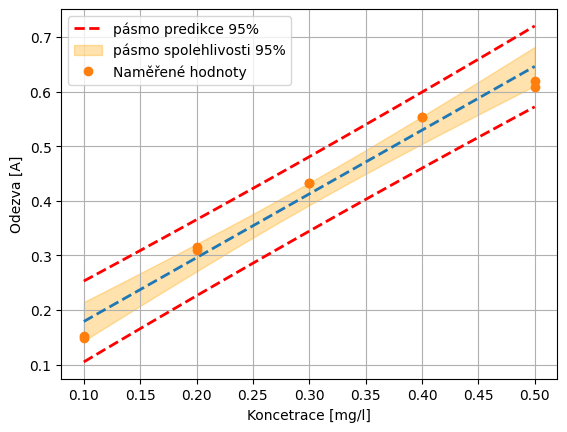

In [6]:
#@title Graf s výsledkem

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy.stats
from IPython.display import display, HTML

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table

import warnings
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ValueWarning)
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def data_extract(R_standards, c_standards, R_sample):
    str1, str2 = c_standards.replace(",", "."), R_standards.replace(",", ".")

    list1, list2, data = str1.split('/'), str2.split('/'), []

    for i in range(len(list2)):
      for num in list2[i].split(';'):
          data.append([float(list1[i]), float(num)])

    data_1 = {}

    for i, block in enumerate(R_sample.replace(",", ".").split("/")):
        data_1[f"Vzorek {i+1}"] = block.split(";")

    df = pd.DataFrame.from_dict(data_1, orient='index').T.astype('float')
    return(pd.DataFrame(data, columns=["Concentration", "Signal"]).astype('float'), df)

def count_decimals(x):
  if isinstance(x, float):
      return len(str(x).split('.')[1])
  else:
      return 0

def outlier_value(model, df, samples):
  residuals = model.resid
  Sxy = np.sqrt(model.scale)
  df["G"] = abs(residuals) / Sxy * np.sqrt(model.nobs/model.df_resid)
  t_crit = scipy.stats.t.ppf(1 - 0.1/(2*model.nobs), df=model.df_resid)
  G_crit = ((model.nobs-1) * t_crit) / np.sqrt(model.nobs * (model.df_resid + t_crit**2))

  def highlight_rows(row):
    if row['G'] > G_crit:
        return ['background-color: red']*len(row)
    else:
        return ['']*len(row)

  df_0_decimals, df_1_decimals = df[df.columns[0]].apply(count_decimals).max(), df[df.columns[1]].apply(count_decimals).max()

  df.index = df.index + 1
  df = df.style.apply(highlight_rows, axis=1).format({df.columns[0]: "{:." + str(df_0_decimals) + "f}",
                                                      df.columns[1]: "{:." + str(df_1_decimals) + "f}",
                                                      "G": "{:.2f}"}
                                                     ).set_caption(f'<h2 style="font-weight: bold;">G crit 95% = {G_crit:.2f}</h2>')
  return (df)

def evaluation(model, calibration, samples):
    X, y = calibration.iloc[:,0], calibration.iloc[:,1]
    critical_values = {1: np.nan, 2: np.nan, 3: 0.970, 4: 0.829, 5: 0.710, 6: 0.625, 7: 0.568, 8: 0.526, 9: 0.493, 10: 0.466}

    slope = model.params[-1]
    Sreg = np.sqrt(model.scale)

    result = pd.DataFrame(index=[f'Koncetrace analytu [{c_unit}]', f'Směrodatná odchylka [{c_unit}]', "Relativní směrodatná odchylka %", "Interval spolehlivosti 95%"])
    samples_Q_test = samples.copy().fillna("")
    samples_Q_test.index = samples_Q_test.index + 1

    for i in samples.columns:
        sample = samples[i]
        if intercept == True:
          predict = ((sample - model.params[0])/model.params[-1]).mean() * Fz
        else:
          predict = (sample/model.params[-1]).mean() * Fz

        S_sample = (Sreg/abs(slope))*np.sqrt(1/model.nobs + 1/samples[i].count() + (((sample.mean() - y.mean())**2)/(slope**2 * sum(X-X.mean()**2)))) * Fz
        Rel_std = S_sample/predict * 100
        con_int = S_sample * scipy.stats.t.ppf(q=0.975, df=model.df_resid)

        sig_num = str(float('%.2g' % S_sample))[::-1].find('.')

        result[i] = [predict.round(sig_num), S_sample.round(sig_num), Rel_std.round(1), con_int.round(sig_num)]
        #result.loc["Relativní směrodatná odchylka %"] = result.loc["Relativní směrodatná odchylka %"].apply(lambda x: format(x, '.1f'))

    round_num = samples.iloc[:,0].apply(count_decimals).max()

    samples_Q_test.loc["Průměr"] = samples.mean().round(round_num)
    samples_Q_test.loc['-----'] = '-----'
    if DeanDixon_test == True:
        samples_Q_test.loc["Qmax"] = ((samples.max() - samples.apply(lambda x: x.nlargest(2).iloc[-1])) / (samples.max() - samples.min())).round(3)
        samples_Q_test.loc["Qmin"] = ((samples.apply(lambda x: x.nsmallest(2).iloc[-1]) - samples.min()) / (samples.max() - samples.min())).round(3)
        samples_Q_test.loc["Qcrit"] = (samples.count().map(critical_values.get)).round(3)
        samples_Q_test.loc[' ----- '] = ' ----- '

    new_df = pd.concat([samples_Q_test, result], axis=0)
    return (new_df)

def intervals(model, df):
    x = df["Concentration"]
    y = df["Signal"]
    t = scipy.stats.t.ppf(0.975, model.df_resid)
    x_line = np.linspace(np.min(x), np.max(x), 100)

    if intercept == True:
      y_line = model.predict(sm.add_constant(x_line))
    else:
      y_line = model.predict(x_line)

    ci = t * np.sqrt(model.scale) * (1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5
    pi = t * np.sqrt(model.scale) * (1 + 1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5

    return(pd.DataFrame([x_line, y_line,  y_line+pi, y_line-pi, y_line+ci, y_line-ci], index = ["x","y", "upp_ci", "under_ci", "upp_pi", "under_pi"]).T)

calibration, samples = data_extract(R_standards, c_standards, R_sample)

if intercept == True:
  model = sm.OLS(calibration.iloc[:,1], sm.add_constant(calibration.iloc[:,0])).fit()
else:
  model = sm.OLS(calibration.iloc[:,1], calibration.iloc[:,0]).fit()

if full_summary == True:
    print(model.summary())
else:
    print('\n'.join(str(model.summary().tables[0]).split('\n')[:4]))
    print(model.summary().tables[1])

if intercept == True:
  if model.pvalues[0] > 0.05:
    print()
    display(HTML('<p style="font-size: 15pt; font-weight: bold; color: red;">Úsek je nevýznamný</p>'))
  else:
    print()
    display(HTML('<p style="font-size: 15pt; font-weight: bold;">Úsek je významný</p>'))

display(HTML("<h2>Grubbsův test odhelých hodnot</h2>"))
display(outlier_value(model, calibration, samples))
print("")
display(HTML("<h2>Vyhodnocení vzorků</h2>"))
display(evaluation(model, calibration, samples))
print("")

x, y = calibration.iloc[:,0].values, calibration.iloc[:,1].values
intervals = intervals(model, calibration)

#plt.rcParams["figure.figsize"] = (19,9)
plt.plot(intervals["x"], intervals["y"], '--', lw=2)
plt.plot(intervals["x"], intervals["under_ci"], 'r--', lw=2)
plt.plot(intervals["x"], intervals["upp_ci"], 'r--', lw=2, label="pásmo predikce 95%")
plt.fill_between(intervals["x"], intervals["under_pi"], intervals["upp_pi"] , color='orange', alpha=0.32, label="pásmo spolehlivosti 95%")
plt.plot(x, y, 'o', label="Naměřené hodnoty")

plt.legend()
plt.grid()
plt.xlabel(f"Koncetrace [{c_unit}]")
plt.ylabel(f"Odezva [{R_unit}]")
plt.show()